In [2]:
import numpy as np
import pandas as pd

In [3]:
raw = pd.read_csv('train.csv', index_col=['PassengerId'])

In [4]:
raw.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
raw.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [6]:
raw.count()

Survived    891
Pclass      891
Name        891
Sex         891
Age         714
SibSp       891
Parch       891
Ticket      891
Fare        891
Cabin       204
Embarked    889
dtype: int64

# Quick Assessment of survival rate

In [7]:
raw['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [8]:
raw.groupby("Sex")['Survived'].sum()

Sex
female    233
male      109
Name: Survived, dtype: int64

In [9]:
raw['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [10]:
raw.groupby('Pclass')['Survived'].sum()

Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64

In [11]:
def survival_rate(survival_series, total_series):
    s = pd.concat([survival_series, total_series], axis=1, sort=True)
    s['rate'] = s.iloc[:, 0] / s.iloc[:, 1] * 100
    return s

In [12]:
survival_rate(raw.groupby('Sex')['Survived'].sum(), raw['Sex'].value_counts())

,Survived,Sex,rate
female,233,314,74.203822
male,109,577,18.890815


In [13]:
survival_rate(raw.groupby('Pclass')['Survived'].sum(), raw['Pclass'].value_counts())

,Survived,Pclass,rate
1,136,216,62.962963
2,87,184,47.282609
3,119,491,24.236253


# Prepare model data and convert categorical value to numeric

In [14]:
data = raw[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Survived']].copy()
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,
1,3,male,22.0,1,0,7.2500,NaN,S,0
2,1,female,38.0,1,0,71.2833,C85,C,1
3,3,female,26.0,0,0,7.9250,NaN,S,1
4,1,female,35.0,1,0,53.1000,C123,S,1
5,3,male,35.0,0,0,8.0500,NaN,S,0


In [15]:
data.replace({'Sex': {'male': 1, 'female': 0}}, inplace=True)

In [16]:
data['Age'].fillna(data['Age'].mean(), inplace=True)

In [17]:
data['Embarked'].fillna('S', inplace=True)
data['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [18]:
data['Embarked'] = data['Embarked'].astype('category').cat.codes
data['Cabin'] = data['Cabin'].astype('category').cat.codes
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,
1,3,1,22.0,1,0,7.2500,-1,2,0
2,1,0,38.0,1,0,71.2833,81,0,1
3,3,0,26.0,0,0,7.9250,-1,2,1
4,1,0,35.0,1,0,53.1000,55,2,1
5,3,1,35.0,0,0,8.0500,-1,2,0


# Build Training Model with default parameter values
## DecisionTreeClassifier https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data['Survived'], test_size=.2)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 8), (179, 8), (712,), (179,))

In [21]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [22]:
# Which features are 
clf.feature_importances_, clf.get_depth(), clf.get_n_leaves()

(array([0.06315778, 0.31929127, 0.25030438, 0.04184075, 0.02911536,
        0.21350186, 0.06790226, 0.01488634]), 20, 152)

In [23]:
!conda install -y graphviz

Solving environment: done

# All requested packages already installed.



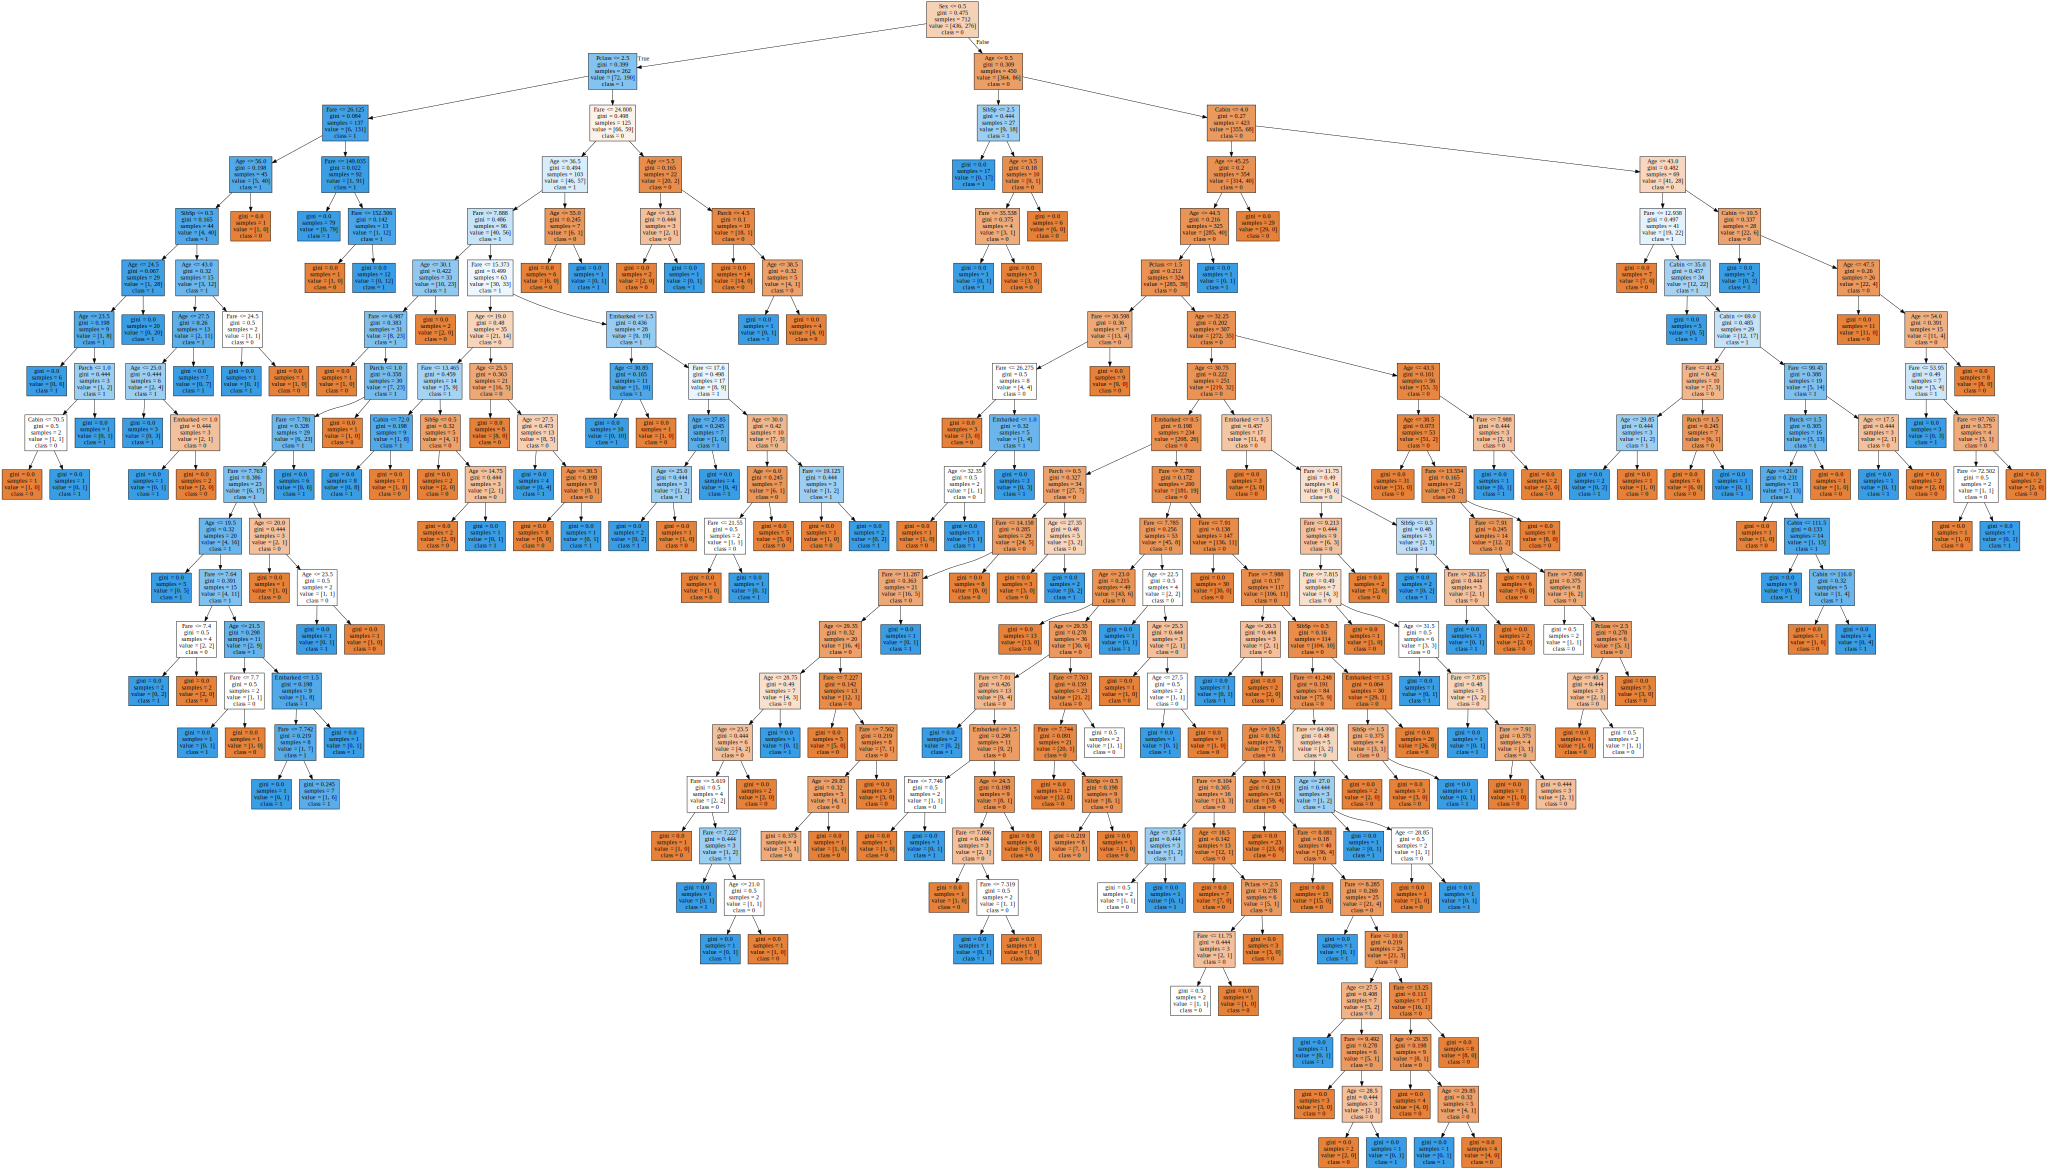

In [24]:
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(clf, class_names=['0', '1'], filled=True,
                                feature_names=['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked'])
graph = graphviz.Source(dot_data)
graph

# Overfitting
# Cross Validation https://en.wikipedia.org/wiki/Cross-validation_(statistics)

In [25]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9873595505617978
0.8100558659217877


In [26]:
from sklearn.model_selection import cross_val_score

In [27]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print(np.mean(scores))

[0.81944444 0.66901408 0.73239437 0.76760563 0.8028169 ]
0.7582550860719875


# Parameter Tuning
- What if we reduce the number of leaf nodes from 162 to 10, what will happend to accuracy?
- What is the ideal # of leaf nodes for our model?

In [28]:
clf = DecisionTreeClassifier(max_leaf_nodes=10)
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print(np.mean(scores))

[0.84027778 0.78169014 0.79577465 0.78873239 0.83802817]
0.8089006259780908


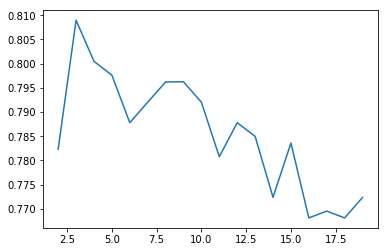

In [29]:
%matplotlib inline

accuracy = []
number_depth = list(range(2, 20))
for n in number_depth:
    clf = DecisionTreeClassifier(max_depth=n)
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=5)    
    accuracy.append(np.mean(scores))


import matplotlib.pyplot as plt
plt.plot(number_depth, accuracy)
plt.show()

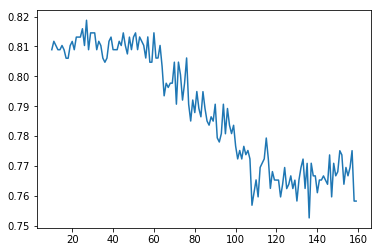

In [30]:
accuracy = []
number_leaf_nodes = list(range(10, 160))
for n in number_leaf_nodes:
    clf = DecisionTreeClassifier(max_leaf_nodes=n)
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=5)    
    accuracy.append(np.mean(scores))


import matplotlib.pyplot as plt
plt.plot(number_leaf_nodes, accuracy)
plt.show()

# Hperparameter Tuning: https://en.wikipedia.org/wiki/Hyperparameter_optimization

In [42]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,20),
    'max_leaf_nodes': range(20,40)
}

clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=-1, cv=5, iid=False)
clf.fit(X_train, y_train)
clf.best_params_

{'criterion': 'gini', 'max_depth': 11, 'max_leaf_nodes': 25}

In [43]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8946629213483146
0.8212290502793296


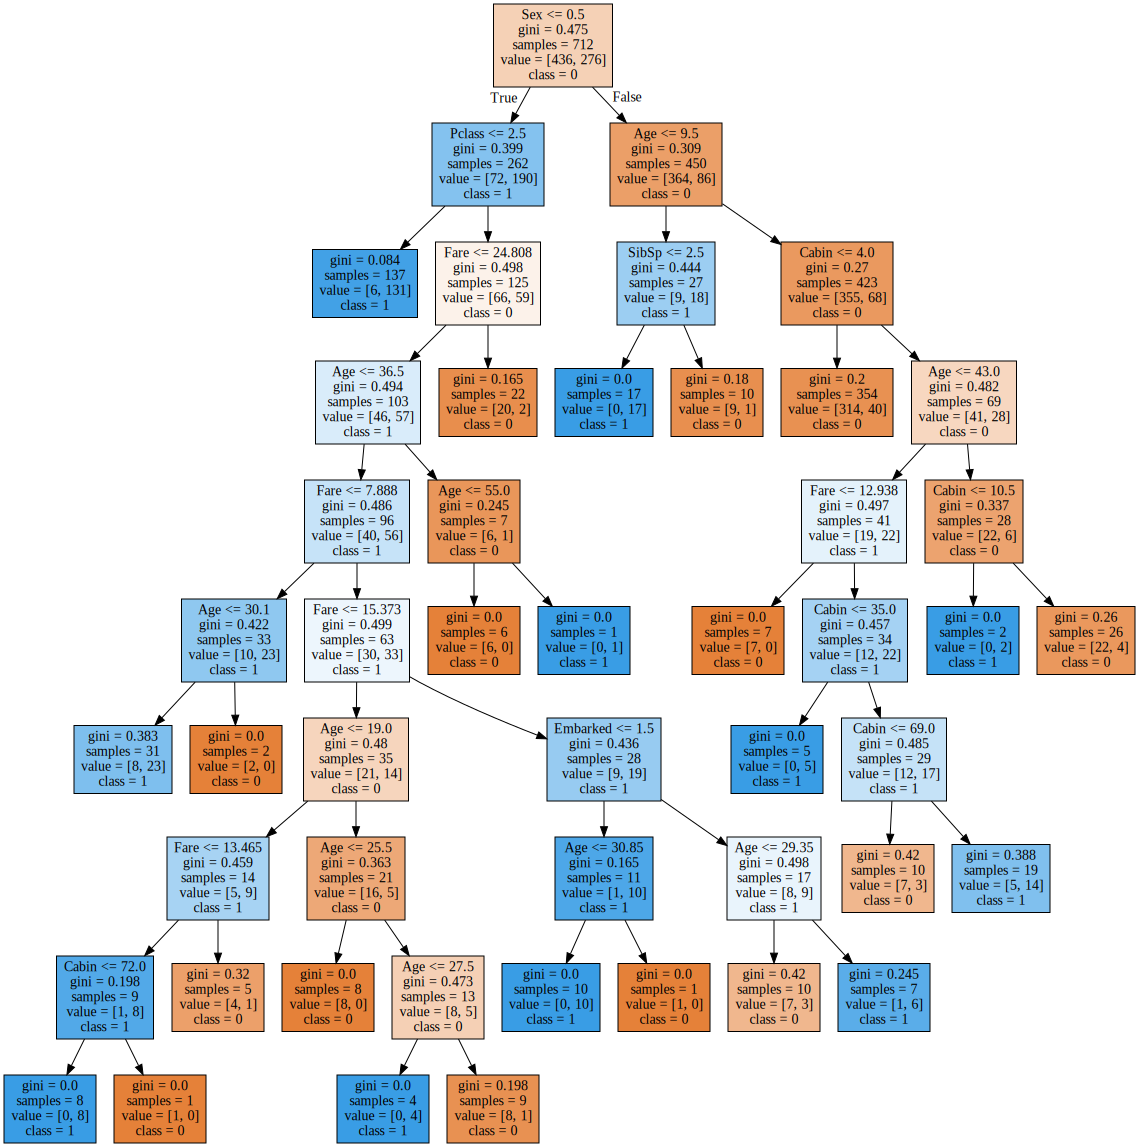

In [46]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=11, max_leaf_nodes=25)
clf.fit(X_train, y_train)
dot_data = tree.export_graphviz(clf, class_names=['0', '1'], filled=True,
                                feature_names=['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked'])
graph = graphviz.Source(dot_data)
graph

# Ensemble Learning
- Bagging (Bootstraping Samplling): https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29
- Randome Sample: https://en.wikipedia.org/wiki/Sampling_(statistics)
- Random Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
rf_clf.fit(X_train, y_train)
print(rf_clf.score(X_train, y_train))
print(rf_clf.score(X_test, y_test))

0.9873595505617978
0.8268156424581006


In [36]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': range(2,20),
    'max_leaf_nodes': range(20,40)
}

# Make sure to specify "n_jobs" which controls # of jobs to run in parallel.
clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, cv=5, iid=False)
clf.fit(X_train, y_train)
clf.best_params_

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


{'criterion': 'gini',
 'max_depth': 10,
 'max_leaf_nodes': 37,
 'n_estimators': 50}

In [37]:
print(rf_clf.score(X_train, y_train))
print(rf_clf.score(X_test, y_test))

0.9873595505617978
0.8268156424581006


# Gradient Boost: https://xgboost.readthedocs.io/en/latest/

In [39]:
!conda install -y xgboost

Solving environment: done

## Package Plan ##

  environment location: /home/ming/anaconda3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    libxgboost-0.82            |       he1b5a44_0         3.9 MB  conda-forge
    py-xgboost-0.82            |   py37he1b5a44_0          70 KB  conda-forge
    xgboost-0.82               |   py37he1b5a44_0           9 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will be INSTALLED:

  _py-xgboost-mutex  conda-forge/linux-64::_py-xgboost-mutex-2.0-cpu_0
  libxgboost         conda-forge/linux-64::libxgboost-0.82-he1b5a44_0
  py-xgboost         conda-forge/linux-64::py-xgboost-0.82-py37he1b5a44_0
  xgboost        

In [40]:
from xgboost.sklearn import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
print(xgb_clf.score(X_train, y_train))
print(xgb_clf.score(X_test, y_test))

0.8834269662921348
0.8268156424581006


# If you run this script several times, you will notice the accuracy is different each time. What's the effect of randome_state parameter of train_test_split()?